In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Parameters
training_set_size = 0.2
randomized_labels = False
mislabel_percentage = 1.0

In [39]:
# Load data
file_path_data = "TCGAdata.txt"
file_path_labels = "TCGAlabels.txt"
df_data = pd.read_csv(file_path_data, delim_whitespace=True, header=0, quotechar='"')
df_labels = pd.read_csv(
    file_path_labels, delim_whitespace=True, header=0, quotechar='"'
)
df = pd.merge(df_data, df_labels, left_index=True, right_index=True, how="left")

In [40]:
# Print all unique labels in the last column of df
print(df.iloc[:, -1].unique())

['GBM' 'BC' 'OV' 'LU' 'KI' 'U']


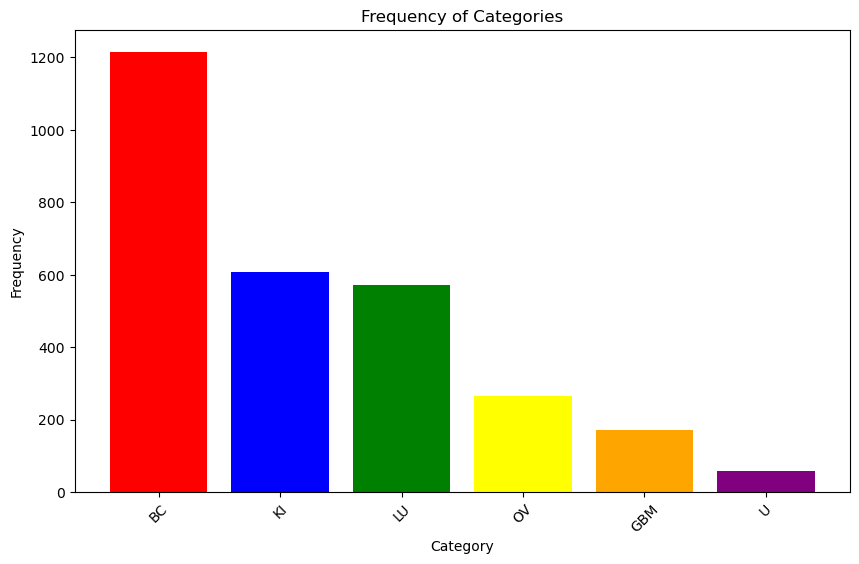

In [41]:
# Count the occurrences of each category
category_counts = df.iloc[:, -1].value_counts()

# Create a dictionary to map each class to a color
class_colors = {'BC': 'red', 'KI': 'blue', 'LU': 'green', 'OV': 'yellow', 'GBM': 'orange', 'U': 'purple'}

# Create a list of colors for each bar using the mapped colors
colors = [class_colors.get(category, 'gray') for category in category_counts.index]

# Create a bar chart with unique colors
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color=colors)

# Add labels and title if needed
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Frequency of Categories')

# Adjust the xticks if they are overlapping
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [42]:
# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=20),
}

In [43]:
# Create a df for every x
df_BC = df[df["x"] == "BC"]
df_KI = df[df["x"] == "KI"]
df_LU = df[df["x"] == "LU"]
df_OV = df[df["x"] == "OV"]
df_GBM = df[df["x"] == "GBM"]
df_U = df[df["x"] == "U"]

In [44]:
##### Section for mislabelling a percentage of y_test #####
# Function to mislabel a percentage of the data
def randomize_labels(labels, percentage=10):
    n_total = len(labels)
    n_change = int(n_total * (percentage / 100))
    indices_to_change = np.random.choice(n_total, n_change, replace=False)
    #print(n_total)

    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Mislabeling logic
    new_labels = labels.copy()
    for index in indices_to_change:
        original_label = labels.iloc[index]
        possible_labels = unique_labels[unique_labels != original_label]
        new_labels.iloc[index] = np.random.choice(possible_labels)
    #print(f"NEW LABELS shape {indices_to_change}")
    return new_labels, indices_to_change

In [45]:
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]  # Labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=training_set_size, random_state=42
)

In [46]:
# Randomizing labels in y_test
if randomized_labels:
    mislabel_percentage = 1  # Change this as needed
    y_train_randomized, indices_change = randomize_labels(y_train, percentage=mislabel_percentage)

In [47]:
standardize = True
apply_pca = True

if standardize:
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

if apply_pca:
    pca = PCA(n_components=20)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

{'GBM': 1, 'BC': 1, 'OV': 1, 'LU': 2, 'KI': 4, 'U': 2}


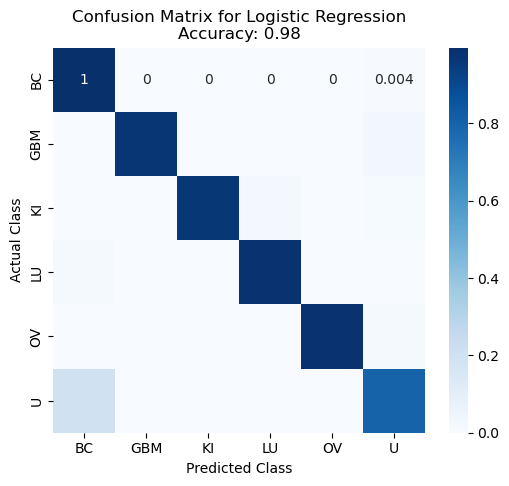

Logistic Regression accuracy: 0.9809688581314879


In [48]:
clf = classifiers["KNN"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize="true")
dict = {'GBM': 0, 'BC': 0, 'OV': 0, 'LU': 0, 'KI': 0, 'U': 0}
class_labels = sorted(set(y_test)) 
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        dict[y_test.iloc[i]] += 1
print(dict)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion Matrix for Logistic Regression\nAccuracy: {accuracy:.2f}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print(f"Logistic Regression accuracy: {accuracy}")

{'GBM': 2, 'BC': 2, 'OV': 2, 'LU': 4, 'KI': 7, 'U': 5}


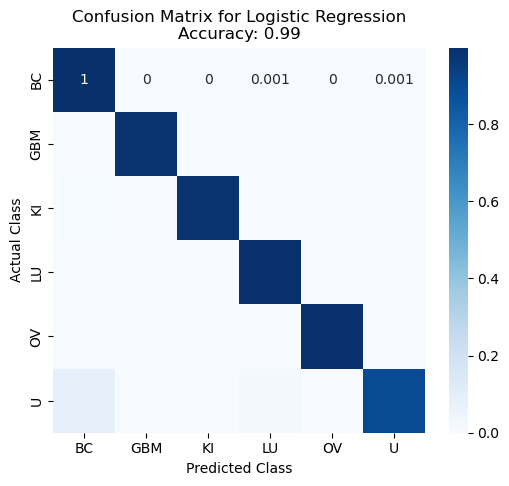

Logistic Regression accuracy: 0.9904720658293633
0.9900404729038135


In [49]:
clf = classifiers["KNN"]

cv_scores = cross_val_score(clf, X_train, y_train, cv=kf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
cm = confusion_matrix(y_train, y_pred, normalize="true")
dict = {'GBM': 0, 'BC': 0, 'OV': 0, 'LU': 0, 'KI': 0, 'U': 0}
class_labels = sorted(set(y_train)) 
for i in range(len(y_train)):
    if y_train.iloc[i] != y_pred[i]:
        dict[y_train.iloc[i]] += 1
print(dict)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion Matrix for Logistic Regression\nAccuracy: {accuracy:.2f}')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print(f"Logistic Regression accuracy: {accuracy}")
print(np.mean(cv_scores))